<a href="https://colab.research.google.com/github/Dicere/WB_Internship/blob/main/0_8_model_new_feature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.9 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from catboost import CatBoostClassifier,Pool
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, classification_report, recall_score, precision_recall_curve,precision_score, precision_recall_fscore_support
import statsmodels.api as sm
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('/content/drive/MyDrive/WB_стажировка/wb_school_task_2.csv.gzip',compression='gzip')
df = df.drop_duplicates(ignore_index=True)

In [5]:
kvad_sum=(lambda x: sum(i**2 for i in x))
kvad_sum.__name__ = 'kvad_sum'

interkvartil_razmah = (lambda x: np.percentile(x, 75) - np.percentile(x, 25))
interkvartil_razmah.__name__ = 'interkvartil_razmah'

range_dannih = (lambda x: x.max()-x.min())
range_dannih.__name__ = 'range_dannih'

quant90 = lambda x: x.quantile(0.9)
quant90.__name__ = 'quant90'

In [6]:
aggs_list = ['min','max', 'mean', 'median', 'count', 'sum',kvad_sum,interkvartil_razmah,range_dannih,quant90]

In [7]:
df_agg = df[['id3','f1','f2','f3','f4','f5','f6','f7','f8']].groupby(by=['id3']).agg(aggs_list).reset_index()
df_agg.columns = ['_by_id3_'.join(col) for col in df_agg.columns.values]
df_agg = df_agg.rename(columns={'id3_by_id3_':'id3'})

In [8]:
df1 = pd.merge(df,df_agg,how='left',on=['id3'])

In [9]:
clear_df = df1[['f1','f2','f3','f4','f5','f6','f7','f8','f1_by_id3_sum', 'f2_by_id3_sum', 'f3_by_id3_sum', 'f4_by_id3_sum',
       'f5_by_id3_sum', 'f6_by_id3_sum', 'f7_by_id3_sum', 'f8_by_id3_sum']]

In [10]:
feature_dict = {}
def summ(b=0,i=0):
  name = str('sum_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
  feature_dict[name] = clear_df.iloc[:,b] + clear_df.iloc[:,i]
def subtraction(b=0,i=0):
    name = str('subtraction_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
    feature_dict[name] = abs(clear_df.iloc[:,b] - clear_df.iloc[:,i])
def multiplication(b=0,i=0):
    name = str('multiplication_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
    feature_dict[name] = abs(clear_df.iloc[:,b] * clear_df.iloc[:,i])
def division(b=0,i=0):
    name = str('division_'+clear_df.columns[b] +"_"+ clear_df.columns[i])
    feature_dict[name] = abs((clear_df.iloc[:,b] / clear_df.iloc[:,i]).fillna(0))
    name = str('division_'+clear_df.columns[i]+"_"+clear_df.columns[b])
    feature_dict[name] = abs((clear_df.iloc[:,i] /clear_df.iloc[:,b]).fillna(0))

In [11]:
conversions_list = {'sum':summ,'subtraction':subtraction,'division':division,'multiplication':multiplication}

In [12]:
idx=0
for conv in conversions_list.keys():
  for b in range(len(clear_df.columns)-1):
    if conv == 'multiplication':
      for i in range(b,len(clear_df.columns)):
        conversions_list[conv](b,i)
    else:
      for i in range(b+1,len(clear_df.columns)):
        conversions_list[conv](b,i)


In [13]:
df1 = df1.assign(**feature_dict)

<ipython-input-13-56533d6d9c93>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1 = df1.assign(**feature_dict)
<ipython-input-13-56533d6d9c93>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1 = df1.assign(**feature_dict)
<ipython-input-13-56533d6d9c93>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.co

In [14]:
cols_to_drop = df1.columns[df1.nunique() == 1]
df1 = df1.drop(cols_to_drop, axis=1)
df1.replace([np.inf, -np.inf], 0, inplace=True)

In [15]:
X = df1[df1.drop('label', axis=1).columns[4::]]
y=df1.label

In [16]:
N_SPLITS = 7
current_feat = list(X.columns[:8])

In [17]:
columns = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f1_by_id3_median', 'f6_by_id3_interkvartil_razmah', 'f7_by_id3_mean', 'sum_f3_f6', 'division_f1_f2', 'division_f4_f7', 'division_f7_f5', 'division_f7_f8', 'multiplication_f3_f3']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [19]:
def calc_log_loss_weight(y_true):
    y_true = y_true.astype(int)
    nc = np.bincount(y_true)
    w0, w1 = 1/(nc[0]/y_true.shape[0]), 1/(nc[1]/y_true.shape[0])
    return w0, w1

In [20]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=22)
indx_all = X_train.index

oof = pd.DataFrame(data=np.zeros((len(indx_all),1)), index=indx_all)
# params_grid = {'bootstrap_type': 'MVS',
#         'iterations': 800,
#         'learning_rate': 0.259,
#         'max_depth': 3,
#         'objective': 'Logloss',
#         'verbose': 200,
#         'eval_metric': 'AUC',
#         'border_count': 32,
#         'colsample_bylevel': 0.09715577437674092,
#         'min_data_in_leaf': 20,
#         'random_strength': 0.36494249753665964,
#         'scale_pos_weight': 0.4366210135974975
#         }

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
models=[]
for idx, (train_idx, test_idx) in enumerate(cv.split(X_train, y_train)):
    print('#'*25)
    print('### CV_Fold',idx+1)
    print('#'*25)

    X_train_сv, X_val_сv = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_сv, y_val_сv = y_train.iloc[train_idx], y_train.iloc[test_idx]

    train_w0, train_w1 = calc_log_loss_weight(y_train_сv)
    valid_w0, valid_w1 = calc_log_loss_weight(y_val_сv)

    train_pool = Pool(X_train_сv[columns], y_train_сv,weight=y_train_сv.map({0: train_w0, 1: train_w1}), feature_names=columns)
    test_pool = Pool(X_val_сv[columns], y_val_сv,weight=y_val_сv.map({0: train_w0, 1: train_w1}), feature_names=columns)

    clf = CatBoostClassifier()
    clf.fit(train_pool,
            eval_set=test_pool,
            verbose=0)
    models.append(clf)
    oof.loc[X_val_сv.index,0] = clf.predict_proba(X_val_сv.astype('float32'))[:,1]
    y_pred_metki = clf.predict(X_val_сv)
    y_pred = clf.predict_proba(X_val_сv)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_val_сv, y_pred)
    print("AUC_ROC----"+str(roc_auc_score(y_val_сv, y_pred)))
    print("F1-score-----"+str(f1_score(y_val_сv, y_pred_metki,average='macro')))

#########################
### CV_Fold 1
#########################
AUC_ROC----0.7642868906455862
F1-score-----0.6702181633688482
#########################
### CV_Fold 2
#########################
AUC_ROC----0.7004693675889329
F1-score-----0.6444022995317964
#########################
### CV_Fold 3
#########################
AUC_ROC----0.7771653868384112
F1-score-----0.6922204536410664
#########################
### CV_Fold 4
#########################
AUC_ROC----0.7619209809264305
F1-score-----0.6697284324870532
#########################
### CV_Fold 5
#########################
AUC_ROC----0.7397820163487738
F1-score-----0.6538054841842862


In [21]:
scores = []; thresholds = []
best_score = 0; best_threshold = 0
true = y_train
for threshold in np.arange(0.05,0.97,0.001):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.05, 0.05, 0.05, 0.05, 0.05, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.07, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.09, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.12, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.13, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.14, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.17, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.18, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.19, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.20, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.22, 0.22

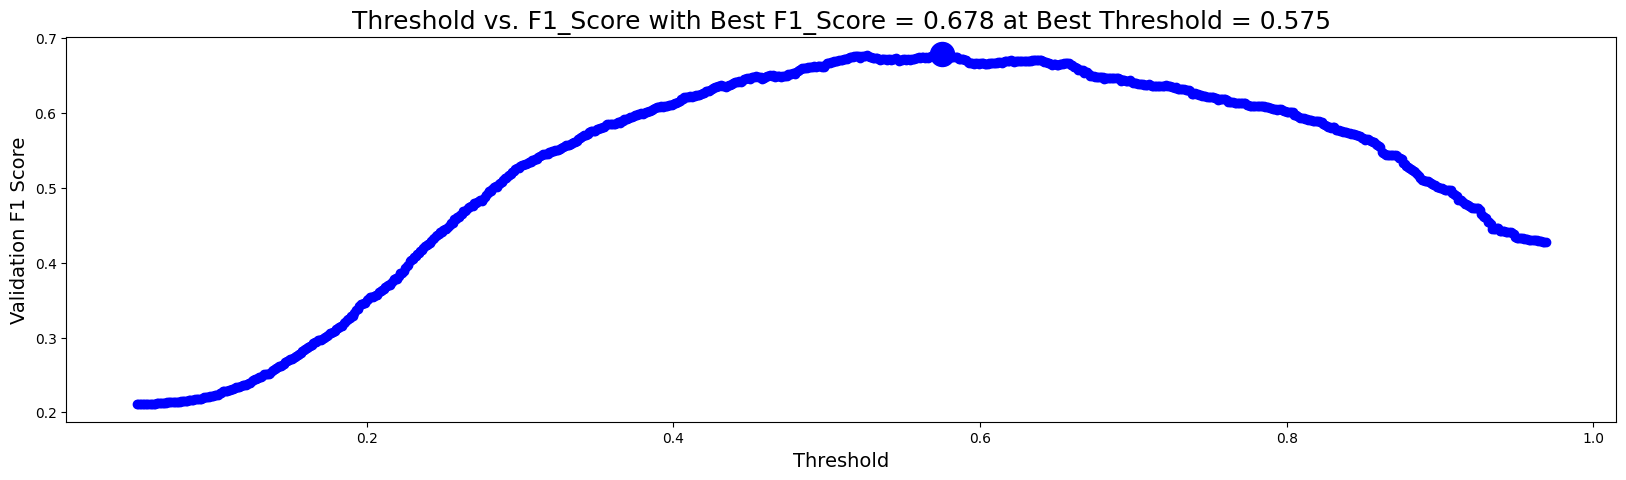

In [22]:
# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [23]:
preds = (oof.values.reshape((-1))>best_threshold).astype('int')
print(precision_score(true, preds))
print(recall_score(true, preds))

0.5946502057613169
0.43787878787878787
